# Simulation code

## Imports

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time
import statsmodels.api as sm

## Non-linear models

These three models transform the vector of explanatory variables $S_t$ into a vector of nonlinear transformed variables $G(S_t;\varphi)$.

In [11]:
def TR_model(S_t, gamma):
    return (S_t >= gamma).astype(float).reshape(-1, 1)

def LSTR_model(S_t,gamma,tau):
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1)

def ESTR_model(S_t,gamma,tau):
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1)

## Test statistics TR

In [286]:
def cal_g_theta_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create an array of gamma value that are used in the for loop
    gamma_quantile = np.linspace(0.15,0.85,grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     TR_model(S_t,np.quantile(S_t,gamma_quantile[i])))))
                                                                     for i in range(grid_elements)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements))

    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]


    
    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)

    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]
    
    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

## Test statistics LSTR

In [13]:
def cal_g_theta_LSTR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and tau values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    tau_array = np.repeat(np.linspace(0.1,5,grid_elements),grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     LSTR_model(S_t,np.quantile(S_t,gamma_quantile[i]),tau_array[i]))))
                                                                     for i in range(grid_elements**2)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]

    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

## Test statistics ESTR


In [14]:
def cal_g_theta_ESTR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and tau values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    tau_array = np.repeat(np.linspace(0.1,5,grid_elements),grid_elements)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     ESTR_model(S_t,np.quantile(S_t,gamma_quantile[i]),tau_array[i]))))
                                                                     for i in range(grid_elements**2)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]

    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

## Simulation 1

In [15]:
# Simple method to estimate the OLS estimates
def estimateBeta(Z_t,Y_t):
    return np.linalg.inv(np.transpose(Z_t) @ Z_t) @ np.transpose(Z_t) @ Y_t

In [24]:
def MonteCarlo_1(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_1)(R,P,T) for i in range(MC_iterations))
        
    else:
        MC_array = np.zeros(MC_iterations)    
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i] = MonteCarlo_iteration_1(R,P,T)    
        
    # Return the rejection rate
    return np.mean(MC_array)

def MonteCarlo_iteration_1(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the corresponding lost function of interest
        delta_L = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size,T_size)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
        
        elif (model_type=="TV-TR"):
            return cal_g_theta_TV_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-LSTR"):
            return cal_g_theta_TV_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-ESTR"):
            return cal_g_theta_TV_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
        
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_1(R_size, P_size, T_size)

    
def sim_model_1(T_size):

    # Initialize delta1, delta2 and v
    delta1 = delta2 = v = 1

    # Simulate the model
    z1 = np.random.normal(0,1,(T_size,1))
    z2 = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta1 * z1 + delta2 * z2 + np.random.normal(0, 1, (T_size,1))

    # Return parameter vectors
    return z1, z2, y_t, S_t


def cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size):
    
    # Compile z1 and z2
    sim_z1 = np.column_stack([np.ones((T_size,1)),sim_z1])
    sim_z2 = np.column_stack([np.ones((T_size,1)),sim_z2])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z1_sel = sim_z1[t-R_size:t-1]
        z2_sel = sim_z2[t-R_size:t-1]
        y_sel = sim_y_t[t-R_size:t-1]
        
        # Estimate the linear regression estimates
        beta_1 = estimateBeta(z1_sel,y_sel)
        beta_2 = estimateBeta(z2_sel,y_sel)

        # Estimate the two forecasts
        forecast1 = beta_1[0] + sim_z1[t,1] * beta_1[1]
        forecast2 = beta_2[0] + sim_z2[t,1] * beta_2[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast1)**2 - (sim_y_t[t] - forecast2)**2
    
    # Return the vector of the loss function of interest
    return delta_L

In [42]:
#simulation speed:
MC_iterations = 1
grid_elements = 20
iterations_CV = 100
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = False
barlett_kernel = False

print("---TR model---")
model_type = "TR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))
        
print("---LSTR model---")
model_type = "LSTR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))
        
print("---ESTR model---")
model_type = "ESTR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))

---TR model---
For R = 25
And P = 50
The rejection rate is 0.0
For R = 25
And P = 100
The rejection rate is 0.0
For R = 25
And P = 200
The rejection rate is 0.0
For R = 25
And P = 1000
The rejection rate is 1.0
For R = 50
And P = 50
The rejection rate is 0.0
For R = 50
And P = 100
The rejection rate is 0.0
For R = 50
And P = 200
The rejection rate is 0.0
For R = 50
And P = 1000
The rejection rate is 0.0
For R = 100
And P = 50


<ipython-input-41-ff0cc37de568>:15: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i], _, _ = MonteCarlo_iteration_1(R,P,T)


The rejection rate is 0.0
For R = 100
And P = 100
The rejection rate is 0.0
For R = 100
And P = 200
The rejection rate is 0.0
For R = 100
And P = 1000
The rejection rate is 0.0
---LSTR model---
For R = 25
And P = 50
The rejection rate is 0.0
For R = 25
And P = 100
The rejection rate is 0.0
For R = 25
And P = 200
The rejection rate is 0.0
For R = 25
And P = 1000
The rejection rate is 0.0
For R = 50
And P = 50
The rejection rate is 0.0
For R = 50
And P = 100
The rejection rate is 0.0
For R = 50
And P = 200
The rejection rate is 0.0
For R = 50
And P = 1000
The rejection rate is 0.0
For R = 100
And P = 50
The rejection rate is 0.0
For R = 100
And P = 100
The rejection rate is 0.0
For R = 100
And P = 200
The rejection rate is 0.0
For R = 100
And P = 1000
The rejection rate is 0.0
---ESTR model---
For R = 25
And P = 50
The rejection rate is 0.0
For R = 25
And P = 100
The rejection rate is 0.0
For R = 25
And P = 200
The rejection rate is 0.0
For R = 25
And P = 1000
The rejection rate is 0.0
F

# Simulation 2

In [50]:
def MonteCarlo_2(R_size,P_size,T_size,c):
    
    if (parallelization == True):
        # Define variable to keep track of amount of rejects
        MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_2)(R_size,P_size,T_size,c) for i in range(MC_iterations))
        
    else:
        MC_array = np.zeros(MC_iterations)    
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i] = MonteCarlo_iteration_2(R_size,P_size,T_size,c)    
    
    # Return the rejection rate
    return np.mean(MC_array)

def MonteCarlo_iteration_2(R_size,P_size,T_size,c):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the old corresponding lost function of interest
        delta_L_1 = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size)
        
        # Normalize delta_L_1
        delta_L_1 = delta_L_1 / np.std(delta_L_1)
        
        # Calculate the new corresponding lost function of interest
        delta_L = cal_delta_L_2(delta_L_1,sim_S_t[R_size-1:T_size-1],c)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
        
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_1(R_size, P_size, T_size)


def cal_delta_L_2(delta_L_old,S_sel,c):
    
    # Initialize gamma
    gamma = 0
    
    # Determine mu and theta by a choice of c
    mu = np.linspace(0,1,c_length)[c]
    theta = -2*mu
    
    # Calculate the new loss function of interest
    delta_L = delta_L_old + mu + theta * TR_model(S_sel,gamma)
    
    # Return the loss function of interest
    return delta_L

In [135]:
# First, we want to determine the significance level for size-adjustment

# Global variables that determine the accuracy of the outcome
MC_iterations = 10
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Values for P to loop over
P_MC_array = [50,100,200]

# Initiliaze R and horizon h
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.012
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.014
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.013
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

# Determine the rejection rate of the models given the model and P = 50
P_MC = 100
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.030
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.032
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.030
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "LSTR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))
    
model_type = "ESTR"
signi_level = 0.040
print(MonteCarlo_2(R_MC,P_MC,T_MC,0))

0.0
0.1
0.1
0.1
0.0
0.0
0.0
0.0
0.1


[0.  0.  0.1 0.5 0.5 0.9 1.  1.  1.  1.  1. ]
[0.1 0.  0.1 0.3 0.7 0.8 1.  0.9 1.  1.  1. ]
[0.  0.1 0.1 0.2 0.6 0.6 0.7 1.  1.  1.  1. ]


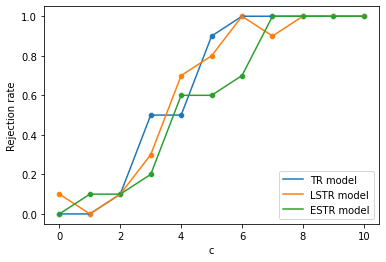

[0.  0.  0.5 1.  1.  1.  1.  1.  1.  1.  1. ]
[0.  0.5 0.6 1.  1.  1.  1.  1.  1.  1.  1. ]
[0.1 0.2 0.6 0.8 1.  1.  1.  1.  1.  1.  1. ]


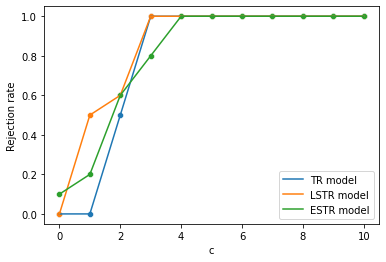

In [53]:
# Global variables that determine the accuracy of the outcome
MC_iterations = 10
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Global variable to set the significance level
signi_level = 0.05

# Values for P to loop over
P_MC_array = [50,100,200]
c_array = np.arange(c_length)

# Initiliaze R
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Initialize empty array
rejection_array = np.zeros(c_length)

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.012
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')
        
model_type = "LSTR"
signi_level = 0.014
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='LSTR model')
        
model_type = "ESTR"
signi_level = 0.013
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='ESTR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')
    
model_type = "LSTR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='LSTR model')
    
model_type = "ESTR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_2(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='ESTR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

# Simulation 3

In [53]:
def MonteCarlo_3(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_3)(R,P,T) for i in range(MC_iterations))
        
        # Get everything out of the Results
        MC_array = np.array([result[0] for result in Results])
        value_delta_L = np.array([result[1] for result in Results])
        
    else:
        MC_array = np.zeros(MC_iterations)    
        value_delta_L = np.zeros(MC_iterations)
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i], value_delta_L[i] = MonteCarlo_iteration_3(R,P,T)    
        
    # Return the rejection rate
    return np.mean(MC_array), np.mean(value_delta_L)

def MonteCarlo_iteration_3(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    
    try:
        
        # Simulate the model
        sim_z_t, sim_y_t, sim_S_t = sim_model_3(T_size)
        
        # Calculate the corresponding lost function of interest
        if (window_type=="ROLREC"):
            delta_L = cal_delta_L_3_ROLREC(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="ROLFIX"):
            delta_L = cal_delta_L_3_ROLFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="RECFIX"):
            delta_L = cal_delta_L_3_RECFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        else:
            raise Exception("Window type unknown")
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), (np.sum(delta_L > 0) / P_size > 0.5).astype(int)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_3(R_size, P_size, T_size)

    
def sim_model_3(T_size):

    # Initialize delta and v
    delta = v = 1

    # Simulate the model
    z_t = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta * z_t + np.random.normal(0, 1, (T_size,1))

    # Return parameter vectors
    return z_t, y_t, S_t


def cal_delta_L_3_ROLREC(sim_z_t, sim_y_t, R_size, P_size, T_size):
    # Compile z_t
    sim_z_t = np.column_stack([np.ones((T_size,1)),sim_z_t])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel_ROL = sim_z_t[t-R_size:t-1]
        z_sel_REC = sim_z_t[0:t-1]
        y_sel_ROL = sim_y_t[t-R_size:t-1]
        y_sel_REC = sim_y_t[0:t-1]
        
        # Estimate the linear regression estimates
        beta_ROL = estimateBeta(z_sel_ROL,y_sel_ROL)
        beta_REC = estimateBeta(z_sel_REC,y_sel_REC)
        
        # Estimate the two forecasts
        forecast_ROL = beta_ROL[0] + sim_z_t[t,1] * beta_ROL[1]
        forecast_REC = beta_REC[0] + sim_z_t[t,1] * beta_REC[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast_ROL)**2 - (sim_y_t[t] - forecast_REC)**2

    # Return the vector of the loss function of interest
    return delta_L

def cal_delta_L_3_ROLFIX(sim_z_t, sim_y_t, R_size, P_size, T_size):
    
    # Compile z_t
    sim_z_t = np.column_stack([np.ones((T_size,1)),sim_z_t])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    z_sel_FIX = sim_z_t[0:R_size-1]
    y_sel_FIX = sim_y_t[0:R_size-1]
    
    beta_FIX = estimateBeta(z_sel_FIX,y_sel_FIX)
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel_ROL = sim_z_t[t-R_size:t-1]
        y_sel_ROL = sim_y_t[t-R_size:t-1]
        
        # Estimate the linear regression estimates
        beta_ROL = estimateBeta(z_sel_ROL,y_sel_ROL)

        # Estimate the two forecasts
        forecast_ROL = beta_ROL[0] + sim_z_t[t,1] * beta_ROL[1]
        forecast_FIX = beta_FIX[0] + sim_z_t[t,1] * beta_FIX[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast_ROL)**2 - (sim_y_t[t] - forecast_FIX)**2

    # Return the vector of the loss function of interest
    return delta_L

def cal_delta_L_3_RECFIX(sim_z_t, sim_y_t, R_size, P_size, T_size):
    
    # Compile z_t
    sim_z_t = np.column_stack([np.ones((T_size,1)),sim_z_t])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
    
    z_sel_FIX = sim_z_t[0:R_size-1]
    y_sel_FIX = sim_y_t[0:R_size-1]
    
    beta_FIX = estimateBeta(z_sel_FIX,y_sel_FIX)
    
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel_REC = sim_z_t[0:t-1]
        y_sel_REC = sim_y_t[0:t-1]
        
        # Estimate the linear regression estimates
        beta_REC = estimateBeta(z_sel_REC,y_sel_REC)

        # Estimate the two forecasts
        forecast_REC = beta_REC[0] + sim_z_t[t,1] * beta_REC[1]
        forecast_FIX = beta_FIX[0] + sim_z_t[t,1] * beta_FIX[1]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast_REC)**2 - (sim_y_t[t] - forecast_FIX)**2

    # Return the vector of the loss function of interest
    return delta_L

In [54]:
#simulation speed:
MC_iterations = 10
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = False
barlett_kernel = True
model_type = "TR"


print("---ROLREC model---")
window_type = "ROLREC"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_3(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---ROLFIX model---")
window_type = "ROLFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_3(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---RECFIX model---")
window_type = "RECFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_3(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)

---ROLREC model---
For R = 25
And P = 50
The rejection rate is 0.0
The rate of delta_L being positive is 0.7
For R = 25
And P = 100


<ipython-input-53-a7d70d5b1be4>:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i], value_delta_L[i] = MonteCarlo_iteration_3(R,P,T)


The rejection rate is 0.0
The rate of delta_L being positive is 0.7
For R = 25
And P = 200
The rejection rate is 0.2
The rate of delta_L being positive is 0.9
For R = 25
And P = 1000
The rejection rate is 1.0
The rate of delta_L being positive is 1.0
For R = 50
And P = 50
The rejection rate is 0.1
The rate of delta_L being positive is 0.5
For R = 50
And P = 100
The rejection rate is 0.0
The rate of delta_L being positive is 0.7
For R = 50
And P = 200
The rejection rate is 0.2
The rate of delta_L being positive is 0.8
For R = 50
And P = 1000
The rejection rate is 0.8
The rate of delta_L being positive is 1.0
For R = 100
And P = 50
The rejection rate is 0.2
The rate of delta_L being positive is 0.6
For R = 100
And P = 100
The rejection rate is 0.1
The rate of delta_L being positive is 0.6
For R = 100
And P = 200
The rejection rate is 0.0
The rate of delta_L being positive is 0.4
For R = 100
And P = 1000
The rejection rate is 0.3
The rate of delta_L being positive is 0.8
---ROLFIX model--

# Simulation 4

In [69]:
def MonteCarlo_4(R,P,T):
    
    if (parallelization == True):    
        # Define variable to keep track of amount of rejects
        Results = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_4)(R,P,T) for i in range(MC_iterations))
        
        # Get everything out of the Results
        MC_array = np.array([result[0] for result in Results])
        value_delta_L = np.array([result[1] for result in Results])
        
    else:
        MC_array = np.zeros(MC_iterations)    
        value_delta_L = np.zeros(MC_iterations)
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i], value_delta_L[i] = MonteCarlo_iteration_4(R,P,T)    
        
    # Return the rejection rate
    return np.mean(MC_array), np.mean(value_delta_L)

def MonteCarlo_iteration_4(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    
    try:
        
        # Simulate the model
        sim_z_t, sim_y_t, sim_S_t = sim_model_4(T_size)

        # Calculate the corresponding lost function of interest
        if (window_type=="ROLREC"):
            delta_L = cal_delta_L_3_ROLREC(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="ROLFIX"):
            delta_L = cal_delta_L_3_ROLFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        elif (window_type=="RECFIX"):
            delta_L = cal_delta_L_3_RECFIX(sim_z_t, sim_y_t, R_size, P_size,T_size)
        else:
            raise Exception("Window type unknown")
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), (np.sum(delta_L > 0) / P_size > 0.5).astype(int)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size), np.sum(delta_L > 0) / P_size
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_4(R_size, P_size, T_size)

    
def sim_model_4(T_size):

    # Initialize and v
    v = 1
    
    steps = np.random.normal(0, 0.1, size=T_size)
    delta_t = (np.cumsum(steps) + 1).reshape(T_size,1)

    # Simulate the model
    z_t = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta_t * z_t + np.random.normal(0, 1, (T_size,1))
    # Return parameter vectors
    return z_t, y_t, S_t

In [71]:
#simulation speed:
MC_iterations = 10
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = True
barlett_kernel = True
model_type = "TR"


print("---ROLREC model---")
window_type = "ROLREC"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_4(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---ROLFIX model---")
window_type = "ROLFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_4(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)
        
print("---RECFIX model---")
window_type = "RECFIX"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        rejection_rates, delta_L_rate = MonteCarlo_4(R_MC,P_MC,T_MC)
        print("The rejection rate is",rejection_rates)
        print("The rate of delta_L being positive is",delta_L_rate)

---ROLREC model---
For R = 25
And P = 50
The rejection rate is 0.3
The rate of delta_L being positive is 0.4
For R = 25
And P = 100
The rejection rate is 0.3
The rate of delta_L being positive is 0.4
For R = 25
And P = 200
The rejection rate is 0.4
The rate of delta_L being positive is 0.2
For R = 25
And P = 1000
The rejection rate is 0.9
The rate of delta_L being positive is 0.1
For R = 50
And P = 50
The rejection rate is 0.2
The rate of delta_L being positive is 0.3
For R = 50
And P = 100
The rejection rate is 0.4
The rate of delta_L being positive is 0.1
For R = 50
And P = 200
The rejection rate is 0.4
The rate of delta_L being positive is 0.1
For R = 50
And P = 1000
The rejection rate is 1.0
The rate of delta_L being positive is 0.0
For R = 100
And P = 50
The rejection rate is 0.3
The rate of delta_L being positive is 0.2
For R = 100
And P = 100
The rejection rate is 0.7
The rate of delta_L being positive is 0.1
For R = 100
And P = 200
The rejection rate is 0.4
The rate of delta_L 

# Simulation 5

In [226]:
def MonteCarlo_5(R,P,T):
    
    if (parallelization == True):    
        
        # Define variable to keep track of amount of rejects
        loss_mean = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_5)(R,P,T) for i in range(MC_iterations))
                
    else:
        loss_mean = np.zeros(P)    
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            loss_mean += (MonteCarlo_iteration_5(R,P,T))

    # Return the rejection rate
    return loss_mean / MC_iterations

def MonteCarlo_iteration_5(R_size,P_size,T_size):
    # Sometimes the method has an error, because there is a singular matrix
    
    try:
        # Simulate the model
        sim_z_1, sim_z_2, sim_z_3, sim_z_4, sim_y_t, sim_S_t = sim_model_5(T_size)

        delta_L = cal_delta_L_5(sim_z_1, sim_z_2, sim_z_3, sim_z_4, sim_y_t, R_size, P_size,T_size)
        
        return np.transpose(np.absolute(delta_L))[0]
    
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_4(R_size, P_size, T_size)

    
def sim_model_5(T_size):

    # Initialize and v
    v = 1
    delta1 = 0.1
    delta2 = 0
    delta3 = 0.1
    delta4 = 0
    
    # Simulate the model
    z_1 = np.random.normal(0,1,(T_size,1))
    z_2 = np.random.normal(0,1,(T_size,1))
    z_3 = np.random.normal(0,1,(T_size,1))
    z_4 = np.random.normal(0,1,(T_size,1))
    S_t = np.random.normal(0,1,(T_size,1))
    
    # Calculate the dependent variable
    y_t = v + delta1 * z_1 + delta2 * z_2 + delta3 * z_3 + delta4 * z_4 + np.random.normal(0, 1, (T_size,1))
    
    # Return parameter vectors
    return z_1, z_2, z_3, z_4, y_t, S_t

def cal_delta_L_5(sim_z_1,sim_z_2, sim_z_3, sim_z_4, sim_y_t, R_size, P_size,T_size):
    
    # Compile z_t
    sim_z_t1 = np.column_stack([np.ones((T_size,1)),sim_z_1,sim_z_2])
    sim_z_t2 = np.column_stack([np.ones((T_size,1)),sim_z_3,sim_z_4])
    
    # Initialize the loss function of interest
    delta_L = np.zeros((P_size,1))
        
    # Loop over all t
    for t in range(R_size, T_size):
        
        # Select the parameters for a certain time period
        z_sel1 = sim_z_t1[0:t-1]
        z_sel2 = sim_z_t2[0:t-1]
        y_sel = sim_y_t[0:t-1]
        
        # Estimate the linear regression estimates
        beta1 = estimateBeta(z_sel1,y_sel)
        beta2 = estimateBeta(z_sel2,y_sel)
        
        # Estimate the two forecasts
        forecast1 = beta1[0] + sim_z_t1[t,1] * beta1[1] + sim_z_t1[t,2] * beta1[2]
        forecast2 = beta2[0] + sim_z_t2[t,1] * beta2[1] + sim_z_t2[t,2] * beta2[2]

        # Perform the test of equal predictive ability
        delta_L[t-R_size] = (sim_y_t[t] - forecast1)**2 - (sim_y_t[t] - forecast2)**2 
    # Return the vector of the loss function of interest
    return delta_L

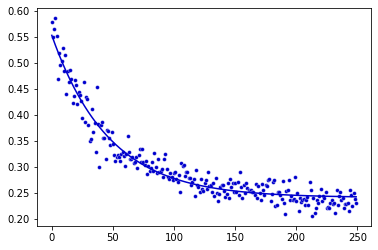

In [250]:
#simulation speed:
MC_iterations = 500

# Values for P to loop over
R_MC = 25
P_MC = 250

# Adjustable variables
parallelization = False

# for i in range(len(P_MC_array)):
T_MC = R_MC + P_MC
loss_array = MonteCarlo_5(R_MC,P_MC,T_MC)

sns.scatterplot(x=np.arange(P_MC), y=loss_array,color='mediumblue',s=15)

def monoExp(x, m, t, b):
    return m * np.exp(-t * x) + b

import scipy.optimize 

params, cv = scipy.optimize.curve_fit(monoExp, np.arange(P_MC), loss_array, (2, .5, 50))
m, t, b = params
sns.lineplot(x=np.arange(P_MC), y=monoExp(np.arange(P_MC), m, t, b),color='mediumblue')

plt.show()

# New Models

In [216]:
def TV_TR_model(S_t, gamma,kappa,T_size):
    return ((S_t >= gamma).astype(float) / (np.exp(-kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))).reshape(-1, 1)

def TV_LSTR_model(S_t,gamma,tau,kappa,T_size):
    return ((1+np.exp(-tau * (S_t-gamma)))**-1).reshape(-1, 1) /(np.exp(kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))

def TV_ESTR_model(S_t,gamma,tau,kappa,T_size):
    return (1-np.exp(-tau * (S_t-gamma)**2)).reshape(-1, 1) /(np.exp(kappa*np.arange(0,T_size)/T_size).reshape(T_size,1))

In [288]:
def cal_g_theta_TV_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and kappa values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    kappa_array = np.tile(np.linspace(0,2,grid_elements),grid_elements)
    
    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     TV_TR_model(S_t,np.quantile(S_t,0.5),kappa_array[i],T_size))))
                                                                     for i in range(grid_elements)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements))

    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]
    
    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)
    
    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)

    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]
    
    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

In [315]:
def cal_g_theta_TV_TR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and kappa values that are used in the for loop
    gamma_quantile = np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements)
    kappa_array = np.repeat(np.linspace(0,2,grid_elements),grid_elements)
    
    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     TV_TR_model(S_t,np.quantile(S_t,gamma_quantile[i]),kappa_array[i],T_size))))
                                                                     for i in range(grid_elements**2)])
    
    # Get psi
#     print("Q",[Q_t[i,R_size-1:R_size+P_size-1] for i in range(grid_elements**2)])
#     print("L:",L_t)
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**2))
    print("psi",psi)
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]
    
    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)
    
    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)

    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]
    
    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

[0.02  0.085 0.305 0.685 0.925 0.985 0.995 1.    1.    1.   ]
[0.01 0.09 0.32 0.72 0.93 0.99 1.   1.   1.   1.  ]


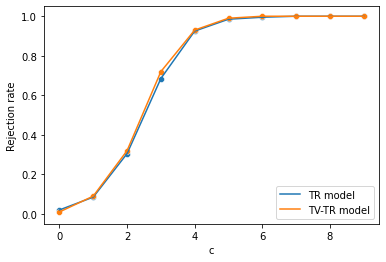

In [320]:
# Global variables that determine the accuracy of the outcome
MC_iterations = 200
grid_elements = 20

iterations_CV = 1000
c_length = 10

# Global variable to set the significance level
signi_level = 0.05

# Values for P to loop over
P_MC_array = [50,100,200]
c_array = np.arange(c_length)

# Initiliaze R
R_MC = 100

# Adjustable variables
parallelization = True
barlett_kernel = False

# Initialize empty array
rejection_array = np.zeros(c_length)

# Determine the rejection rate of the models given the model and P = 50
P_MC = 100
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.024
for c in c_array:
#     print(c)
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')

model_type = "TV-TR"
signi_level = 0.024
for c in c_array:  
#     print(c)
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TV-TR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

In [101]:
def cal_g_theta_TV_LSTR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and tau values that are used in the for loop
    gamma_quantile = np.tile(np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements),grid_elements)
    tau_array = np.tile(np.repeat(np.linspace(0.1,5,grid_elements),grid_elements),grid_elements)
    kappa_array = np.repeat(np.linspace(0,2,grid_elements),grid_elements**2)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     TV_LSTR_model(S_t,np.quantile(S_t,gamma_quantile[i]),tau_array[i],kappa_array[i],T_size))))
                                                                     for i in range(grid_elements**3)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**3))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]

    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

In [102]:
def cal_g_theta_TV_ESTR(S_t, # Vector of S_t
                L_t, # Vector of loss function
                R_size, # Integer
                P_size, # Integer
                T_size, # Integer
                ):

    # Initialize the critical values with a minimum value 
    crit_values = np.full(iterations_CV,-100)

    # Create two arrays of gamma and tau values that are used in the for loop
    gamma_quantile = np.tile(np.tile(np.linspace(0.15,0.85,grid_elements),grid_elements),grid_elements)
    tau_array = np.tile(np.repeat(np.linspace(0.1,5,grid_elements),grid_elements),grid_elements)
    kappa_array = np.repeat(np.linspace(0,2,grid_elements),grid_elements**2)

    # Get Q_t
    Q_t = np.stack([np.column_stack((np.ones((T_size,1)),np.multiply(np.ones((T_size,1)),
                                                                     TV_ESTR_model(S_t,np.quantile(S_t,gamma_quantile[i]),tau_array[i],kappa_array[i],T_size))))
                                                                     for i in range(grid_elements**3)])
    
    # Get psi
    psi = np.stack(estimateBeta(Q_t[i,R_size-1:R_size+P_size-1],L_t) for i in range(grid_elements**3))
    
    # Select values of Q_t
    Q_sel = np.transpose(np.lib.stride_tricks.sliding_window_view(Q_t,R_size,axis=1)[:,:P_size],(0,1,3,2))

    # Calculate the residuals
    residual_sel = L_t - Q_sel[:,:,-1] @ psi

    # Calculate the score and its transpose
    score = Q_sel[:,:,-1] * residual_sel
    score_trans = np.transpose(score, (0, 2, 1))
    
    # Compute V_P, M_P, and its inverse
    V_P = np.transpose(score,(0,2,1)) @ score / P_size
    M_P = np.transpose(Q_sel[:,:,-1],(0,2,1)) @ Q_sel[:,:,-1] / P_size
    M_P_inv = np.stack(np.linalg.inv(M_Ps) for M_Ps in M_P)
    
    # Get V_star and its inverse
    V_star = M_P_inv @ V_P @ M_P_inv
    V_star_inv = np.stack(np.linalg.inv(V_stars) for V_stars in V_star)

    # Then it is possible to calculate W_P
    W_P = P_size * (np.transpose(psi,(0,2,1)) @ V_star_inv @ psi)

    # Get the test statistic of all W_P values
    g_theta = max(W_P)[0][0]

    # This part simulates the critical values, initialize the barlett kernel:
    if (barlett_kernel == False):
        B_size = 0
    
    else:    
        B_size = round(4*(P_size/100)**(2/9)+1)

    # Simulate a matrix of the standard normal distribution
    v_t = np.random.normal(0,1,(P_size+B_size,iterations_CV))
    
    # Calculate lambda_sum and lambda_P
    lambda_sum = score_trans @ np.transpose(np.sum(np.array([np.lib.stride_tricks.sliding_window_view(v_t,P_size,axis=0)[b,:] 
                                                             for b in range(0,B_size+1)]),axis=0))
    lambda_P = np.transpose(lambda_sum / (P_size*(1+B_size))**0.5,(0,2,1))

    # Get the collection of critical values
    W_P_j = np.sum(np.matmul(lambda_P, M_P_inv @ V_star_inv @ M_P_inv) * lambda_P,axis=2)    
    crit_values = np.max(W_P_j,axis=0)

    # Sort the Monte Carlo simulations and get the final critical value
    crit_values = np.sort(crit_values)
    final_crit_value = crit_values[round((1-signi_level) * iterations_CV)-1]

    # Check if the test statistic should be rejected or not
    if (g_theta > final_crit_value):
        return 1
    else:
        return 0

# Simulation 6

In [283]:
#simulation speed:
MC_iterations = 10
grid_elements = 20
iterations_CV = 1000
signi_level = 0.05

# Values for P to loop over
R_MC_array = [25,50,100]
P_MC_array = [50,100,200,1000]

# Adjustable variables
parallelization = False
barlett_kernel = False

print("---TV-TR model---")
model_type = "TV-TR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))
        
print("---TV-LSTR model---")
model_type = "TV-LSTR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))
        
print("---TV-ESTR model---")
model_type = "TV-ESTR"

for R_MC in R_MC_array:
    for P_MC in P_MC_array:
        T_MC = R_MC + P_MC
        print("For R =",R_MC)
        print("And P =",P_MC)
        print("The rejection rate is",MonteCarlo_1(R_MC,P_MC,T_MC))

---TV-TR model---
For R = 25
And P = 50
psi [[[ 1.27519522]
  [-2.75320464]]

 [[ 1.27863276]
  [-2.59048987]]

 [[ 1.27934239]
  [-2.43207757]]

 [[ 1.27730735]
  [-2.27835142]]

 [[ 1.27253797]
  [-2.1296634 ]]

 [[ 1.2650716 ]
  [-1.98632794]]

 [[ 1.25497179]
  [-1.84861707]]

 [[ 1.24232688]
  [-1.7167565 ]]

 [[ 1.22724806]
  [-1.59092302]]

 [[ 1.20986686]
  [-1.47124302]]

 [[ 1.19033235]
  [-1.3577923 ]]

 [[ 1.16880798]
  [-1.25059705]]

 [[ 1.14546836]
  [-1.14963584]]

 [[ 1.12049591]
  [-1.05484265]]

 [[ 1.09407765]
  [-0.96611054]]

 [[ 1.06640213]
  [-0.88329598]]

 [[ 1.03765659]
  [-0.8062236 ]]

 [[ 1.0080244 ]
  [-0.73469103]]

 [[ 0.9776829 ]
  [-0.66847394]]

 [[ 0.94680155]
  [-0.60733089]]]
psi [[[-0.07712175]
  [-0.83672099]]

 [[-0.07404792]
  [-0.78864238]]

 [[-0.07209228]
  [-0.74068377]]

 [[-0.07125101]
  [-0.69321072]]

 [[-0.07150661]
  [-0.6465588 ]]

 [[-0.07282887]
  [-0.60102877]]

 [[-0.07517627]
  [-0.55688325]]

 [[-0.07849757]
  [-0.51434461]]



<ipython-input-24-75f661859cca>:12: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  MC_array[i] = MonteCarlo_iteration_1(R,P,T)


psi [[[ 0.31276653]
  [-0.37782895]]

 [[ 0.3190081 ]
  [-0.36831829]]

 [[ 0.32460805]
  [-0.3573185 ]]

 [[ 0.32953346]
  [-0.34503734]]

 [[ 0.33376004]
  [-0.331685  ]]

 [[ 0.33727261]
  [-0.31747058]]

 [[ 0.34006525]
  [-0.30259851]]

 [[ 0.34214115]
  [-0.28726525]]

 [[ 0.34351225]
  [-0.27165636]]

 [[ 0.34419855]
  [-0.25594393]]

 [[ 0.34422726]
  [-0.24028458]]

 [[ 0.34363184]
  [-0.22481805]]

 [[ 0.34245084]
  [-0.20966633]]

 [[ 0.34072683]
  [-0.19493335]]

 [[ 0.33850518]
  [-0.18070513]]

 [[ 0.33583305]
  [-0.16705049]]

 [[ 0.33275829]
  [-0.15402193]]

 [[ 0.32932861]
  [-0.14165697]]

 [[ 0.32559075]
  [-0.12997956]]

 [[ 0.32158985]
  [-0.1190016 ]]]
psi [[[ 0.91850769]
  [-0.88862008]]

 [[ 0.90961278]
  [-0.81790643]]

 [[ 0.90006777]
  [-0.75093604]]

 [[ 0.88994495]
  [-0.6877602 ]]

 [[ 0.87932495]
  [-0.62840226]]

 [[ 0.86829434]
  [-0.57285572]]

 [[ 0.85694325]
  [-0.52108354]]

 [[ 0.84536281]
  [-0.47301882]]

 [[ 0.8336428 ]
  [-0.42856659]]

 [[ 0.

psi [[[ 0.10598131]
  [ 0.10954992]]

 [[ 0.11192053]
  [ 0.09264467]]

 [[ 0.11807762]
  [ 0.07674284]]

 [[ 0.12437082]
  [ 0.06197627]]

 [[ 0.13071702]
  [ 0.04844455]]

 [[ 0.13703489]
  [ 0.03621299]]

 [[ 0.14324784]
  [ 0.02531253]]

 [[ 0.14928635]
  [ 0.01574148]]

 [[ 0.15508993]
  [ 0.00746884]]

 [[ 0.16060822]
  [ 0.00043869]]

 [[ 0.16580154]
  [-0.00542474]]

 [[ 0.17064085]
  [-0.01021175]]

 [[ 0.1751072 ]
  [-0.01402207]]

 [[ 0.17919081]
  [-0.01696019]]

 [[ 0.18288995]
  [-0.01913133]]

 [[ 0.18620966]
  [-0.02063822]]

 [[ 0.18916048]
  [-0.02157856]]

 [[ 0.19175721]
  [-0.02204324]]

 [[ 0.19401777]
  [-0.02211529]]

 [[ 0.19596223]
  [-0.02186919]]]
psi [[[-0.01891579]
  [ 0.20354396]]

 [[-0.01224768]
  [ 0.18012707]]

 [[-0.0054318 ]
  [ 0.15822134]]

 [[ 0.00144992]
  [ 0.13792377]]

 [[ 0.00831707]
  [ 0.11929508]]

 [[ 0.01509368]
  [ 0.10235975]]

 [[ 0.02171056]
  [ 0.08710783]]

 [[ 0.0281072 ]
  [ 0.0734985 ]]

 [[ 0.03423291]
  [ 0.06146466]]

 [[ 0.

psi [[[-0.1504512 ]
  [ 0.17281358]]

 [[-0.1497233 ]
  [ 0.16008611]]

 [[-0.14888871]
  [ 0.14802463]]

 [[-0.14795853]
  [ 0.13663469]]

 [[-0.1469447 ]
  [ 0.12591616]]

 [[-0.1458598 ]
  [ 0.11586358]]

 [[-0.14471676]
  [ 0.10646645]]

 [[-0.14352867]
  [ 0.09770975]]

 [[-0.14230854]
  [ 0.08957443]]

 [[-0.14106905]
  [ 0.08203802]]

 [[-0.1398224 ]
  [ 0.07507521]]

 [[-0.13858012]
  [ 0.06865848]]

 [[-0.13735292]
  [ 0.06275867]]

 [[-0.13615061]
  [ 0.05734557]]

 [[-0.134982  ]
  [ 0.05238844]]

 [[-0.13385486]
  [ 0.04785646]]

 [[-0.13277591]
  [ 0.04371918]]

 [[-0.13175081]
  [ 0.03994688]]

 [[-0.13078421]
  [ 0.0365108 ]]

 [[-0.12987976]
  [ 0.03338343]]]
psi [[[-0.28495729]
  [ 0.84707945]]

 [[-0.27868107]
  [ 0.77875079]]

 [[-0.27171608]
  [ 0.71425844]]

 [[-0.26410632]
  [ 0.65358418]]

 [[-0.25590237]
  [ 0.59668943]]

 [[-0.24716037]
  [ 0.54351509]]

 [[-0.23794076]
  [ 0.49398213]]

 [[-0.22830702]
  [ 0.44799269]]

 [[-0.21832437]
  [ 0.4054317 ]]

 [[-0.

psi [[[-0.18245677]
  [ 0.25062094]]

 [[-0.18034482]
  [ 0.23321049]]

 [[-0.17768962]
  [ 0.21578671]]

 [[-0.17452953]
  [ 0.19854234]]

 [[-0.17091334]
  [ 0.18165879]]

 [[-0.16689808]
  [ 0.16529997]]

 [[-0.16254642]
  [ 0.14960752]]

 [[-0.15792401]
  [ 0.13469753]]

 [[-0.15309694]
  [ 0.12065903]]

 [[-0.14812947]
  [ 0.10755397]]

 [[-0.14308213]
  [ 0.09541852]]

 [[-0.13801032]
  [ 0.08426546]]

 [[-0.13296329]
  [ 0.07408722]]

 [[-0.12798368]
  [ 0.06485929]]

 [[-0.1231073 ]
  [ 0.05654376]]

 [[-0.11836336]
  [ 0.04909269]]

 [[-0.11377477]
  [ 0.04245123]]

 [[-0.10935878]
  [ 0.03656031]]

 [[-0.10512753]
  [ 0.03135894]]

 [[-0.10108875]
  [ 0.02678603]]]
psi [[[-0.15091928]
  [-0.0054351 ]]

 [[-0.14063856]
  [-0.02462154]]

 [[-0.13061621]
  [-0.04120747]]

 [[-0.12095582]
  [-0.05522981]]

 [[-0.11174999]
  [-0.06677288]]

 [[-0.10307762]
  [-0.07596298]]

 [[-0.09500209]
  [-0.0829613 ]]

 [[-0.08757035]
  [-0.0879556 ]]

 [[-0.08081287]
  [-0.09115161]]

 [[-0.

psi [[[-0.77991777]
  [ 1.26152778]]

 [[-0.78499454]
  [ 1.17591075]]

 [[-0.78938879]
  [ 1.09474239]]

 [[-0.79308422]
  [ 1.01790558]]

 [[-0.79606958]
  [ 0.94528093]]

 [[-0.79833881]
  [ 0.87674608]]

 [[-0.79989096]
  [ 0.81217541]]

 [[-0.80073015]
  [ 0.75143976]]

 [[-0.8008654 ]
  [ 0.69440647]]

 [[-0.80031034]
  [ 0.64093956]]

 [[-0.79908289]
  [ 0.59090008]]

 [[-0.79720491]
  [ 0.54414656]]

 [[-0.79470173]
  [ 0.50053564]]

 [[-0.79160171]
  [ 0.45992266]]

 [[-0.78793575]
  [ 0.42216246]]

 [[-0.78373681]
  [ 0.38711007]]

 [[-0.77903942]
  [ 0.35462145]]

 [[-0.77387923]
  [ 0.32455425]]

 [[-0.76829253]
  [ 0.29676849]]

 [[-0.76231586]
  [ 0.27112717]]]
psi [[[-0.43887323]
  [ 0.74724273]]

 [[-0.42684935]
  [ 0.66947555]]

 [[-0.41467991]
  [ 0.59875652]]

 [[-0.40239981]
  [ 0.53456422]]

 [[-0.39004457]
  [ 0.47640474]]

 [[-0.37764999]
  [ 0.42381089]]

 [[-0.36525179]
  [ 0.37634147]]

 [[-0.35288525]
  [ 0.33358059]]

 [[-0.3405849 ]
  [ 0.29513698]]

 [[-0.

psi [[[-8.16553673e-02]
  [ 5.78505574e-02]]

 [[-7.89132813e-02]
  [ 4.94792498e-02]]

 [[-7.61894445e-02]
  [ 4.18524457e-02]]

 [[-7.35133312e-02]
  [ 3.49738680e-02]]

 [[-7.09128879e-02]
  [ 2.88350658e-02]]

 [[-6.84136883e-02]
  [ 2.34161473e-02]]

 [[-6.60382372e-02]
  [ 1.86870012e-02]]

 [[-6.38054599e-02]
  [ 1.46088946e-02]]

 [[-6.17303937e-02]
  [ 1.11363184e-02]]

 [[-5.98240795e-02]
  [ 8.21894037e-03]]

 [[-5.80936377e-02]
  [ 5.80353587e-03]]

 [[-5.65424979e-02]
  [ 3.83578770e-03]]

 [[-5.51707478e-02]
  [ 2.26187259e-03]]

 [[-5.39755616e-02]
  [ 1.02978268e-03]]

 [[-5.29516721e-02]
  [ 9.03589903e-05]]

 [[-5.20918532e-02]
  [-6.01961817e-04]]

 [[-5.13873879e-02]
  [-1.08866717e-03]]

 [[-5.08285017e-02]
  [-1.40692225e-03]]

 [[-5.04047490e-02]
  [-1.58951837e-03]]

 [[-5.01053461e-02]
  [-1.66497450e-03]]]
psi [[[ 0.17733994]
  [-0.10022652]]

 [[ 0.17989929]
  [-0.09948376]]

 [[ 0.18228001]
  [-0.09811604]]

 [[ 0.18445954]
  [-0.09617109]]

 [[ 0.18641988]


KeyboardInterrupt: 

# Simulation 7

In [282]:
def MonteCarlo_7(R_size,P_size,T_size,c):
    
    if (parallelization == True):
        # Define variable to keep track of amount of rejects
        MC_array = Parallel(n_jobs=6)(delayed(MonteCarlo_iteration_7)(R_size,P_size,T_size,c) for i in range(MC_iterations))
        
    else:
        MC_array = np.zeros(MC_iterations)    
        
        # Define variable to keep track of amount of rejects
        for i in range(MC_iterations):
            MC_array[i] = MonteCarlo_iteration_7(R_size,P_size,T_size,c)    
    
    # Return the rejection rate
    return np.mean(MC_array)

def MonteCarlo_iteration_7(R_size,P_size,T_size,c):
    # Sometimes the method has an error, because there is a singular matrix
    try:
        
        # Simulate the model
        sim_z1, sim_z2, sim_y_t, sim_S_t = sim_model_1(T_size)

        # Calculate the old corresponding lost function of interest
        delta_L_1 = cal_delta_L_1(sim_z1, sim_z2, sim_y_t, R_size, P_size, T_size)
        
        # Normalize delta_L_1
        delta_L_1 = delta_L_1 / np.std(delta_L_1)
        
        # Calculate the new corresponding lost function of interest
        delta_L = cal_delta_L_7(delta_L_1,sim_S_t[R_size-1:T_size-1],c)
    
        # Perform the test on the simulated data for a certain model
        if (model_type=="TR"):
            return cal_g_theta_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="LSTR"):
            return cal_g_theta_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="ESTR"):
            return cal_g_theta_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
        
        elif (model_type=="TV-TR"):
            return cal_g_theta_TV_TR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-LSTR"):
            return cal_g_theta_TV_LSTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        elif (model_type=="TV-ESTR"):
            return cal_g_theta_TV_ESTR(S_t=sim_S_t, L_t=delta_L, R_size=R_size, P_size=P_size, T_size=T_size)
    
        # If we pass another model that is not included, we give an error
        else:
            raise Exception("Model type unknown")
        
    # If there is a LinAlgError, than we want to re-do the method
    except np.linalg.LinAlgError as e:

        return MonteCarlo_iteration_1(R_size, P_size, T_size)


def cal_delta_L_7(delta_L_old,S_sel,c):
    
    # Initialize gamma
    gamma = 0
    
    # Determine mu and theta by a choice of c
    mu = np.linspace(0,1,c_length)[c]
    theta = -2*mu
    
    # Calculate the new loss function of interest
    delta_L = delta_L_old + mu + theta * TR_model(S_sel,gamma) 
#     np.random.uniform(1.5,2)
    
    delta_L = delta_L / (np.exp(2 * np.arange(len(delta_L_old))/len(delta_L_old))).reshape(-1,1)
#     print(delta_L)
    # Return the loss function of interest
    return delta_L

In [105]:
np.exp(np.random.uniform(0,2) * np.arange(100)/100)

array([1.        , 1.01321752, 1.02660974, 1.04017897, 1.05392755,
       1.06785785, 1.08197228, 1.09627327, 1.11076328, 1.12544481,
       1.1403204 , 1.1553926 , 1.17066402, 1.18613729, 1.20181508,
       1.21770009, 1.23379506, 1.25010277, 1.26662602, 1.28336767,
       1.30033061, 1.31751775, 1.33493206, 1.35257655, 1.37045425,
       1.38856825, 1.40692167, 1.42551768, 1.44435949, 1.46345033,
       1.48279351, 1.50239236, 1.52225026, 1.54237062, 1.56275693,
       1.5834127 , 1.60434148, 1.62554689, 1.64703258, 1.66880226,
       1.69085969, 1.71320865, 1.73585301, 1.75879668, 1.7820436 ,
       1.8055978 , 1.82946331, 1.85364428, 1.87814485, 1.90296926,
       1.92812179, 1.95360677, 1.9794286 , 2.00559173, 2.03210067,
       2.05895999, 2.08617433, 2.11374837, 2.14168688, 2.16999466,
       2.1986766 , 2.22773764, 2.2571828 , 2.28701715, 2.31724584,
       2.34787408, 2.37890714, 2.41035038, 2.44220923, 2.47448917,
       2.50719577, 2.54033467, 2.57391159, 2.60793231, 2.64240

In [323]:
# First, we want to determine the significance level for size-adjustment

# Global variables that determine the accuracy of the outcome
MC_iterations = 100
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Values for P to loop over
P_MC_array = [50,100,200]

# Initiliaze R and horizon h
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.022
print(MonteCarlo_7(R_MC,P_MC,T_MC,0))
    
model_type = "TV-TR"
signi_level = 0.022
print(MonteCarlo_7(R_MC,P_MC,T_MC,0))
    
# # Determine the rejection rate of the models given the model and P = 50
# P_MC = 200
# T_MC = P_MC + R_MC
    
# model_type = "TR"
# signi_level = 0.040
# print(MonteCarlo_7(R_MC,P_MC,T_MC,0))
    
# model_type = "TV-TR"
# signi_level = 0.040
# print(MonteCarlo_7(R_MC,P_MC,T_MC,0))

0.02
0.04


[0.05 0.04 0.21 0.2  0.36 0.47 0.68 0.74 0.87 0.88 0.95]
[0.05 0.04 0.08 0.25 0.37 0.56 0.72 0.71 0.83 0.92 0.93]


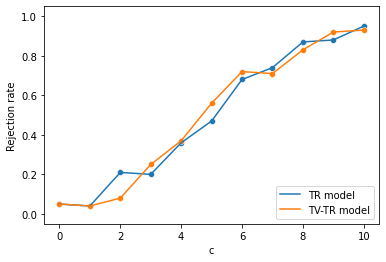

[0.08 0.1  0.32 0.73 0.92 0.99 1.   1.   1.   1.   1.  ]
[0.06 0.11 0.38 0.74 0.9  0.99 1.   1.   1.   1.   1.  ]


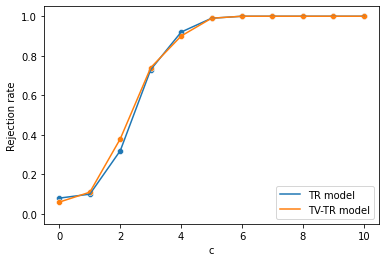

In [118]:
# Global variables that determine the accuracy of the outcome
MC_iterations = 100
grid_elements = 20
iterations_CV = 1000
c_length = 11

# Global variable to set the significance level
signi_level = 0.05

# Values for P to loop over
P_MC_array = [50,100,200]
c_array = np.arange(c_length)

# Initiliaze R
R_MC = 50

# Adjustable variables
parallelization = True
barlett_kernel = True

# Initialize empty array
rejection_array = np.zeros(c_length)

# Determine the rejection rate of the models given the model and P = 50
P_MC = 50
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.012
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')

model_type = "TV-TR"
signi_level = 0.012
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TV-TR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()

# Determine the rejection rate of the models given the model and P = 50
P_MC = 200
T_MC = P_MC + R_MC
    
model_type = "TR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TR model')
    
model_type = "LSTR"
signi_level = 0.040
for c in c_array:    
    rejection_array[c] = MonteCarlo_7(R_MC,P_MC,T_MC,c)
print(rejection_array)
sns.scatterplot(data=rejection_array)
sns.lineplot(data=rejection_array, label='TV-TR model')
plt.xlabel('c')
plt.ylabel('Rejection rate')
plt.ylim(-0.05, 1.05)
plt.legend(loc='lower right')
plt.show()